In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('tkagg')


In [231]:
class LinearRegression:

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X / (np.amax(y))
        self.y_train = y / (np.amax(y))
        self.N_train = X.shape[0]
        self.M = X.shape[1]


    def to_int_tpl_map(self, line):
        return tuple(map(int, line.strip().split()))


    def fit_from_file(self, file_name=None, file=None):
        if file_name:
            file = open(file_name)
        raw_data = tuple(map(self.to_int_tpl_map, file.readlines()))
        self.M = int(raw_data[0][0])
        self.N_train = int(raw_data[1][0])
        train_data = np.array(raw_data[2:self.N_train+2])
        self.y_train = train_data[:, -1] / np.amax(train_data[:, -1])
        self.X_train = train_data[:,:-1] / np.amax(train_data[:, -1])
        self.N_test = int(raw_data[self.N_train+2][0])
        test_data = np.array(raw_data[self.N_train+3:])
        self.y_test = test_data[:,-1]
        self.X_test = test_data[:,:-1]


    def rmse_loss(self, y_pred):
        return np.sqrt((((y_pred - self.y_train)**2).sum())/self.N_train)

    def SVD(self):
        self.w = np.linalg.pinv(self.X_train) @ self.y_train


    def gradient(self, lr=0.01, batch_size=75, n_epochs=100000):

        def loss_derivative(y, y_pred):
            return -2 * (y - y_pred)
        self.w = np.random.sample(self.M)
        for it in range(n_epochs):
            if it % batch_size == 0:
                y_pred = self.X_train @ self.w
                loss_der = loss_derivative(self.y_train, y_pred)
                grad = (np.array([self.X_train[n]*loss_der[n] for n in range(self.N_train)])).sum(axis=0)/self.N_train
                # print('grad:', ' '.join(map(str, grad)))
            self.w = self.w - lr * grad


    def genetic(self, n_epochs=16, loss_limit = 50000):
        n_gens = 2**n_epochs
        # print(n_gens)
        number_len = 22
        e_len = 5
        gens = (np.random.sample((n_gens, self.M * number_len)) < 0.5).astype('int8')
        for epoch in range(n_epochs):
            # print(epoch)
            # print(gens.shape)
            gens_loss = []
            for gen in gens:
                # print([float(int(gen[i+5])*2.)**((2**np.arange(e_len)*gen[1+5:e_len+1+5]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)])
                # print(-1*sum([2.**((2**np.arange(e_len)*gen[1+5:e_len+1+5]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)]))
                # print([float(int(gen[i+5])*2.)for i in range(e_len+1,number_len)])
                # print((-1**int(gen[0+m])) * sum([(gen[i+m]*2.)**((2**np.arange(e_len)*gen[1+m:e_len+1+m]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)]))
                w = np.array(
                    [
                        (-1**int(gen[0+m])) * sum([(2.**gen[i+m])**((2**np.arange(e_len)*gen[1+m:e_len+1+m]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)])
                        for m in range(0, self.M * number_len, number_len)
                    ]
                )
                # print(w)
                gens_loss.append(self.rmse_loss(self.X_train @ w))
            gens_loss = np.array(gens_loss)
            # print(gens_loss[gens_loss.argsort()])
            sorted_indexes = gens_loss.argsort()
            sorted_gens = gens[sorted_indexes]
            n_gens = n_gens//2
            gens = sorted_gens[np.where(gens_loss[sorted_indexes][:n_gens] < loss_limit)]
            if gens.shape[0]<n_gens:
                gens = np.concatenate((gens, (np.random.sample((n_gens-gens.shape[0], self.M * number_len)) < 0.5).astype('int8')),axis=0)
            if n_gens > 1:
                gens = np.array([[gens[n+((i%2) * (-1**(n%2)))][i] for i in range(self.M * number_len)] for n in range(n_gens)])
                for n in range(n_gens):
                    rand_i = np.random.randint(0, self.M*number_len)
                    gens[n][rand_i] = -gens[n][rand_i]
            # print(gens.shape)
        top_gen = gens[0]
        self.w = np.array(
            [
                (-1**int(top_gen[0+m])) * np.array([(2.**top_gen[i+m])**((2**np.arange(e_len)*top_gen[1+m:e_len+1+m]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)]).sum()
                for m in range(0, self.M * number_len, number_len)
            ]
        )

    def genetic_2(self, n_epochs=1000, population_n = 100, surv_n=None):
        number_len = 22
        e_len = 5
        surv_n = surv_n or int(population_n//20)
        gens = (np.random.sample((population_n, self.M * number_len)) < 0.5).astype('int8')
        for epoch in range(n_epochs):
            gens_loss = []
            for gen in gens:
                w = np.array(
                    [
                        (-1**int(gen[0+m])) * sum([(2.**gen[i+m])**((2**np.arange(e_len)*gen[1+m:e_len+1+m]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)])
                        for m in range(0, self.M * number_len, number_len)
                    ]
                )
                gens_loss.append(self.rmse_loss(self.X_train @ w))
            gens_loss = np.array(gens_loss)
            sorted_indexes = gens_loss.argsort()
            sorted_gens = gens[sorted_indexes]
            top_C = np.array([[sorted_gens[:surv_n][n+((i%2) * (-1**(n%2)))][i] for i in range(self.M * number_len)] for n in range(surv_n)])
            gens = np.concatenate((top_C, (np.random.sample((population_n-surv_n, self.M * number_len)) < 0.5).astype('int8')),axis=0)
            rand_n = np.random.randint(0, surv_n)
            rand_m = np.random.randint(0, self.M*number_len)
            gens[rand_n][rand_m] = -gens[rand_n][rand_m]
        top_gen = gens[0]
        self.w = np.array(
            [
                (-1**int(top_gen[0+m])) * np.array([(2.**top_gen[i+m])**((2**np.arange(e_len)*top_gen[1+m:e_len+1+m]).sum() + e_len + 1 - i ) for i in range(e_len+1,number_len)]).sum()
                for m in range(0, self.M * number_len, number_len)
            ]
        )


    def nrmse_score(self, X_test=None, y_test=None):
        if X_test:
            self.X_test = X_test
        if X_test:
            self.y_test = y_test
        y_pred = self.X_test @ self.w
        return np.sqrt(((y_pred - self.y_test)**2).sum()/self.y_test.shape[0])/(np.amax(self.y_test) - np.amin(self.y_test))


    def smape_score(self, X_test=None, y_test=None):
        if X_test:
            self.X_test = X_test
        if X_test:
            self.y_test = y_test
        y_pred = self.X_test  @ self.w
        return 100/self.y_test.shape[0] * (2*np.abs(y_pred - self.y_test)/(np.abs(self.y_test) + np.abs(y_pred))).sum()


In [232]:
reg = LinearRegression()

In [72]:
reg.fit_from_file("1.txt")
reg.SVD()
print(reg.smape_score())

0.014328874537774096


In [87]:
reg.fit_from_file("2.txt")
grad_res = []
for n_epochs in [100, 500, 1000, 10000, 100000]:
    for batch_size in [100, 75, 50, 20, 10, 5 ,1]:
        for lr in 10.**np.arange(-4, -1):
            reg.gradient(lr=lr, batch_size=batch_size, n_epochs=n_epochs)
            smape = reg.smape_score()
            nrmse = reg.nrmse_score()
            grad_res.append([lr, batch_size, n_epochs, smape, nrmse])
            # print('gradient: lr_%f, batch_size_%d, n_epochs_%d',smape)

sorted_res = sorted(grad_res, key=lambda x: x[4])[:10]
print('grad_top10: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in sorted_res]))

grad_top10: lr    batch size  n epochs    smape   nrmse
 0.01 75 100000 26.213445944444892 0.017366417192188552
0.01 1 100000 25.98474621525909 0.018002143879088627
0.01 5 100000 27.112670186866055 0.018171998859694727
0.01 10 100000 27.59684713741623 0.018187273863677935
0.01 20 100000 27.38601990655287 0.018368273190655936
0.01 100 100000 28.8743298396281 0.01912579351657491
0.01 50 100000 28.342576122650325 0.019461942225753776
0.01 1 10000 52.52896243580159 0.04615388597918634
0.001 1 100000 50.53575758471458 0.04657324150306936
0.01 100 10000 51.896502844179516 0.04754864603545642


In [88]:
grad_top5 = sorted_res

In [90]:
print('grad_top5: lr    batch size  n epochs    smape   nrmse\n', '\n'.join([' '.join(map(str, line)) for line in grad_top5]))

grad_top5: lr    batch size  n epochs    smape   nrmse
 0.01 75 100000 26.213445944444892 0.017366417192188552
0.01 1 100000 25.98474621525909 0.018002143879088627
0.01 5 100000 27.112670186866055 0.018171998859694727
0.01 10 100000 27.59684713741623 0.018187273863677935
0.01 20 100000 27.38601990655287 0.018368273190655936
0.01 100 100000 28.8743298396281 0.01912579351657491
0.01 50 100000 28.342576122650325 0.019461942225753776
0.01 1 10000 52.52896243580159 0.04615388597918634
0.001 1 100000 50.53575758471458 0.04657324150306936
0.01 100 10000 51.896502844179516 0.04754864603545642


In [98]:
grad_x_plot = list(range(100, 1000, 100))
grad_x_plot.extend(list(range(1000, 10000, 1000)))
grad_x_plot.extend(list(range(10000, 110000, 10000)))
grad_y_plot = []
for n_epochs in grad_x_plot:
    print(n_epochs, end='... ')
    grad_top1 = lr=grad_top5[0]
    reg.gradient(lr=grad_top1[0], batch_size=grad_top1[1], n_epochs=n_epochs)
    grad_y_plot.append(reg.smape_score())


100
200
300
400
500
600
700
800
900
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [133]:
grad_x_plot_copy = grad_x_plot.copy()
grad_y_plot_copy = grad_y_plot.copy()

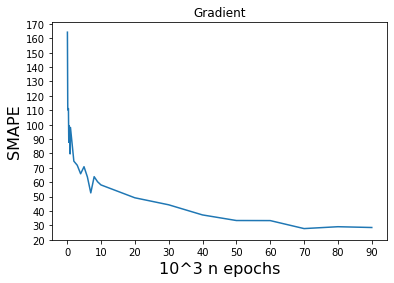

In [180]:
%matplotlib inline
plt.plot([ s/1000 for s in grad_x_plot], grad_y_plot)
plt.title("Gradient")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('10^3 n epochs', fontsize=16)
plt.xticks(list(range(0,100,10)))
plt.yticks(list(range(int(min(grad_y_plot)//10)*10, int(max(grad_y_plot)//10)*10+20,10)))
plt.show()

In [74]:
reg.fit_from_file("3.txt")
reg.genetic()
print(reg.nrmse_score())
print(reg.smape_score())

0
(65536, 198)
[4.34025423e+01 7.53251531e+01 9.14432634e+01 ... 4.94076505e+09
 4.96981587e+09 5.33425588e+09]
(32768, 198)
1
(32768, 198)
[1.20838724e+01 1.22460089e+01 3.19220395e+01 ... 4.78036169e+09
 5.22801612e+09 5.41291702e+09]
(16384, 198)
2
(16384, 198)
[1.82509623e+01 2.55999383e+01 3.47093338e+01 ... 4.75202983e+09
 5.05277962e+09 5.57982567e+09]
(8192, 198)
3
(8192, 198)
[5.60914007e+00 6.47222986e+00 7.32102880e+00 ... 4.61382291e+09
 4.62873696e+09 4.74554848e+09]
(4096, 198)
4
(4096, 198)
[9.89105649e+00 1.02576645e+01 1.37890548e+01 ... 4.47868649e+09
 4.52604735e+09 4.54837563e+09]
(2048, 198)
5
(2048, 198)
[4.39014070e+00 8.13707365e+00 2.17640867e+01 ... 4.37167799e+09
 4.87445948e+09 5.17440560e+09]
(1024, 198)
6
(1024, 198)
[9.82633514e+00 1.32190867e+01 1.86214812e+01 ... 4.26720204e+09
 4.46981516e+09 4.78133303e+09]
(512, 198)
7
(512, 198)
[1.02045848e+01 1.62674891e+01 2.05253350e+01 2.22146372e+01
 2.32839053e+01 2.86835853e+01 3.89746207e+01 4.75180396e+01


In [143]:
reg.fit_from_file("3.txt")
genetic_x_plot = list(range(20))
genetic_y_plot = []
for n_epochs in genetic_x_plot:
    print(n_epochs, end='... ')
    reg.genetic(n_epochs=n_epochs)
    genetic_y_plot.append(reg.smape_score())
    print(' '.join(map(str, genetic_y_plot)))


0... 199.9999873707411
1... 199.9999873707411199.9999986616784
2... 199.9999873707411199.9999986616784199.14185861018723
3... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463
4... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263
5... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263199.99928036233615
6... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263199.99928036233615199.99985629273942
7... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263199.99928036233615199.99985629273942199.86113049741894
8... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263199.99928036233615199.99985629273942199.86113049741894199.7919229963892
9... 199.9999873707411199.9999986616784199.14185861018723199.99999699095463199.9999980732263199.99928036233615199.99985629273942199.86113049741894199.791922996

In [ ]:
genetic_x_plot_copy = genetic_x_plot.copy()
genetic_y_plot_copy = genetic_y_plot.copy()

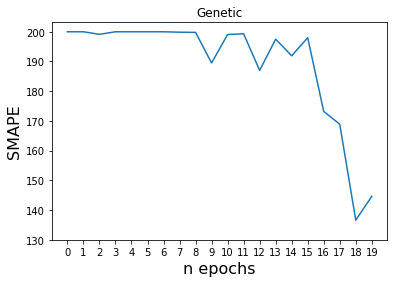

In [182]:
%matplotlib inline
plt.plot(genetic_x_plot, genetic_y_plot)
plt.title("Genetic")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.xticks(list(range(20)))
plt.yticks(list(range(int(min(genetic_y_plot)//10)*10, int(max(genetic_y_plot)//10)*10 + 20,10)))
plt.show()


0... 10... 20... 30... 40... 50... 60... 70... 80... 90... 100... 200... 300... 400... 500... 600... 700... 

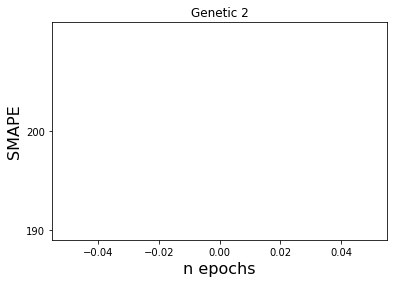

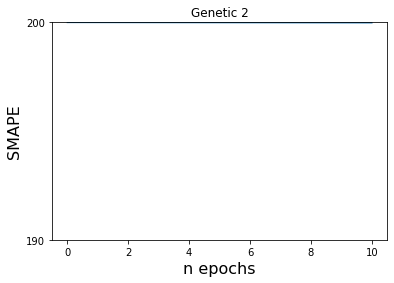

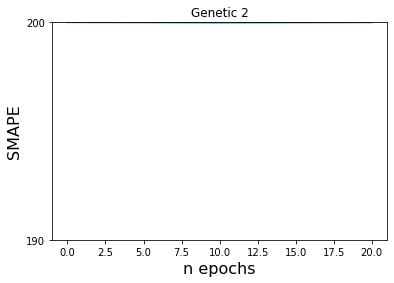

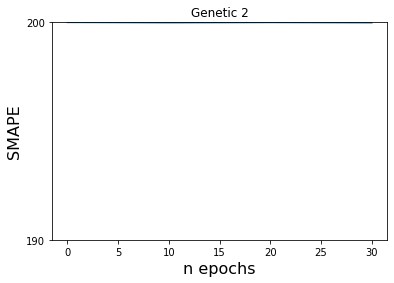

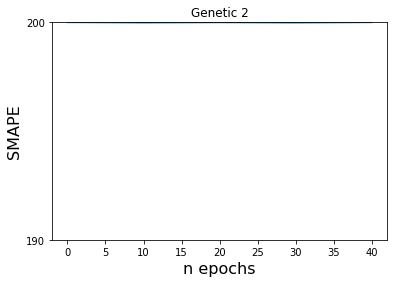

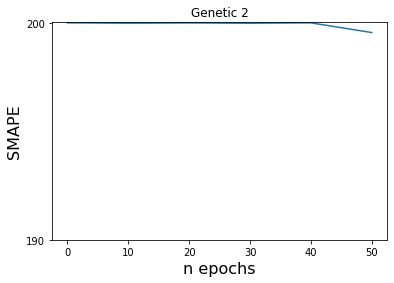

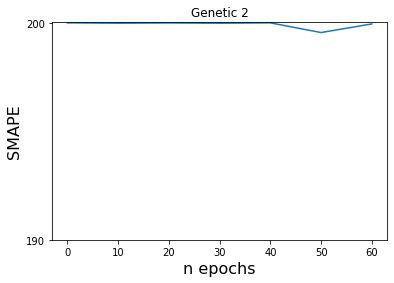

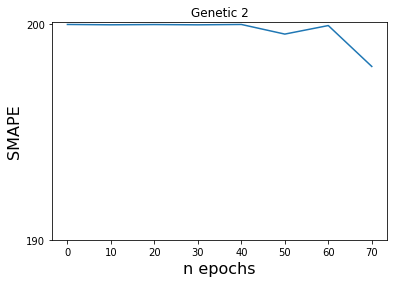

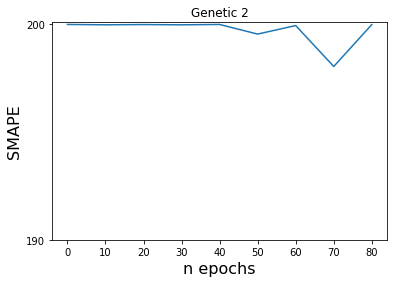

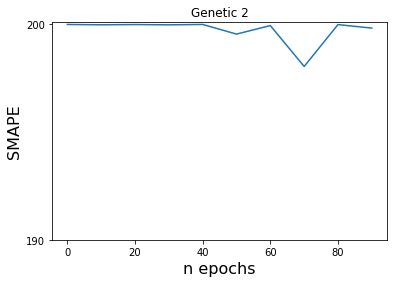

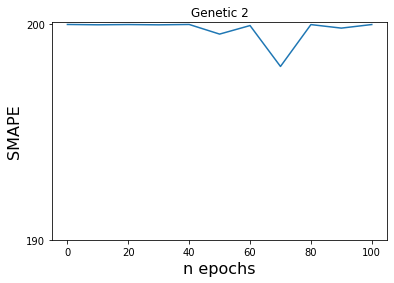

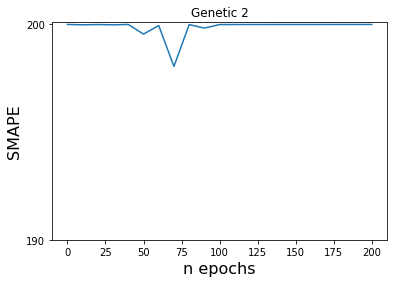

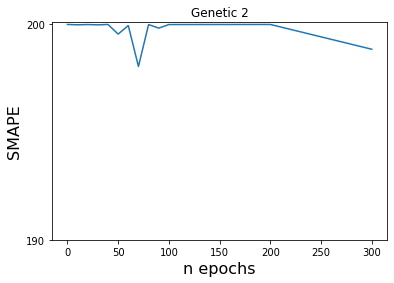

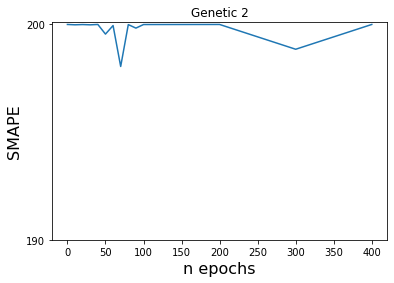

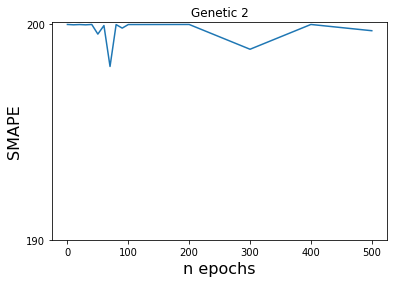

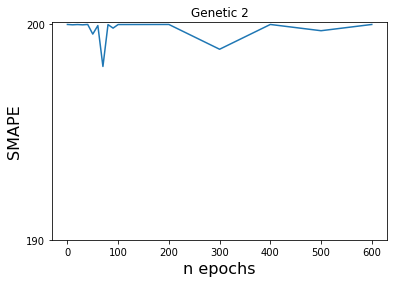

KeyboardInterrupt: 

In [234]:
reg.fit_from_file("3.txt")
genetic_2_x_plot = list(range(0, 100, 10))
genetic_2_x_plot.extend(list(range(100,1000,100)))
# genetic_2_x_plot.extend(list(range(1000,10001,1000)))
genetic_2_y_plot = []
dinamic_x_plot = []
plt.ion()

for n_epochs in genetic_2_x_plot:
    print(n_epochs, end='... ')
    dinamic_x_plot.append(n_epochs)
    reg.genetic_2(n_epochs=n_epochs, population_n=1000, surv_n=10)
    genetic_2_y_plot.append(reg.smape_score())
    plt.plot(dinamic_x_plot, genetic_2_y_plot)
    plt.title("Genetic 2")
    plt.ylabel('SMAPE', fontsize=16)
    plt.xlabel('n epochs', fontsize=16)
    plt.yticks(list(range(int(min(genetic_2_y_plot)//10)*10, int(max(genetic_2_y_plot)//10)*10 + 20,10)))
    plt.draw()
    plt.pause(0.1)
    # print(' '.join(map(str, genetic_2_y_plot)))
plt.ioff()
plt.show()

In [ ]:
genetic_2_x_plot_copy = genetic_2_x_plot.copy()
genetic_2_y_plot_copy = genetic_2_y_plot.copy()

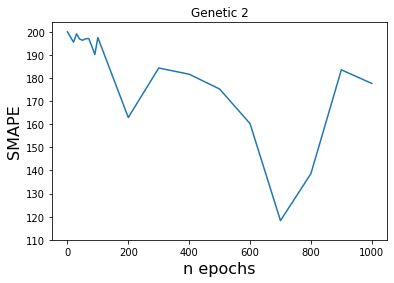

In [219]:
%matplotlib inline
plt.plot(genetic_2_x_plot, genetic_2_y_plot)
plt.title("Genetic 2")
plt.ylabel('SMAPE', fontsize=16)
plt.xlabel('n epochs', fontsize=16)
plt.yticks(list(range(int(min(genetic_2_y_plot)//10)*10, int(max(genetic_2_y_plot)//10)*10 + 20,10)))
plt.show()